In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from utils.pickle_helper import *
from utils.csv_helper import *
from utils.onehot_helper import *

def size(_): print(np.shape(_))

In [2]:
pddf = read_pickle('raw_data.dataframe.bin')
pddf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, ID001 to ID715
Columns: 8077 entries, TOOL_ID_0 to Y
dtypes: float64(6217), int64(1798), object(62)
memory usage: 30.8+ MB


In [3]:
pddf.index

Index(['ID001', 'ID002', 'ID003', 'ID004', 'ID005', 'ID006', 'ID007', 'ID010',
       'ID011', 'ID012',
       ...
       'ID706', 'ID707', 'ID708', 'ID709', 'ID710', 'ID711', 'ID712', 'ID713',
       'ID714', 'ID715'],
      dtype='object', length=500)

In [4]:
# 生成 x, y
x = np.array(pddf.drop(['Y'], axis=1))
y = np.array(pddf['Y'])
size(x)
size(y)

(500, 8076)
(500,)


In [5]:
# 缺失值填充: median 表示中位数, mean 表示平均数
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
# imp = Imputer(missing_values='NaN', strategy='median', axis=0)
x_imp = imp.fit_transform(x)
# x_iimp = imp.inverse_transform(x_imp)
np.shape(x_imp)

(500, 8014)

In [6]:
# 缺失值填充后, 表中缺失列
old_shape, new_shape = len(x[0]), len(x_imp[0])
print('[{0}x500] => [{1}x500]'.format( old_shape, new_shape ))
print('totle lost: ', old_shape - new_shape)
l = len(imp.statistics_)
selected = np.isnan(imp.statistics_)
valid_mask = np.logical_not(selected)
original_column = pddf.columns[:-1]
cnt = 0
for i in range(l):
    if selected[i]:
        print(i, original_column[i], end='\t')
        cnt += 1
        if cnt > 0 and cnt % 5 == 0: print()
print()
remain_column = original_column[valid_mask]

[8076x500] => [8014x500]
totle lost:  62
342 220X150	343 220X151	3728 340X12	3730 340X14	3732 340X16	
3748 340X32	3766 340X50	3768 340X52	3770 340X54	3772 340X56	
3774 340X58	3776 340X60	3778 340X62	3780 340X64	3782 340X66	
3784 340X68	3786 340X70	3788 340X72	3790 340X74	3792 340X76	
3794 340X78	3796 340X80	3798 340X82	3800 340X84	3802 340X86	
3804 340X88	3806 340X90	3808 340X92	3810 340X94	3812 340X96	
3814 340X98	3816 340X100	3818 340X102	3820 340X104	3822 340X106	
3828 340X112	3830 340X114	3832 340X116	3834 340X118	3836 340X120	
3838 340X122	3847 340X131	3858 340X142	3860 340X144	3862 340X146	
3864 340X148	3866 340X150	3868 340X152	3870 340X154	3872 340X156	
3874 340X158	3876 340X160	3878 340X162	3880 340X164	3882 340X166	
3884 340X168	3886 340X170	3888 340X172	3890 340X174	3892 340X176	
3894 340X178	3896 340X180	


In [7]:
# 数据标准化: 最大最小值
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scl = scaler.fit_transform(x_imp)

In [8]:
# 方差筛选: 小于 0.8 * (1 - 0.8) 的方差的特征将被删除
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
x_var = sel.fit_transform(x_scl)
x_ivar = sel.inverse_transform(x_var)

In [9]:
# 方差筛选后, 表中缺失列
old_shape, new_shape = len(x_scl[0]), len(x_var[0])
print('[{0}x500] => [{1}x500]'.format( old_shape, new_shape ))
print('totle lost: ', old_shape - new_shape)
l2 = len(sel._get_support_mask())
selected2 = sel._get_support_mask()
valid_mask = selected2
original_column2 = remain_column
cnt = 0
for i in range(l2):
    if selected2[i]:
        print(str(i).ljust(5), original_column2[i].ljust(12), end='\t')
        cnt += 1
        if cnt > 0 and cnt % 5 == 0: print()
print()
remain_column2 = original_column2[valid_mask]

[8014x500] => [533x500]
totle lost:  7481
2     TOOL_ID_2   	3     TOOL_ID_3   	23    210X18      	209   210X204     	210   210X205     	
217   210X213     	219   210X215     	240   220X3       	253   220X16      	257   220X20      	
283   220X60      	287   220X66      	288   220X67      	289   220X70      	290   220X71      	
291   220X74      	292   220X75      	293   220X78      	294   220X79      	295   220X82      	
296   220X83      	297   220X86      	298   220X87      	299   220X90      	300   220X91      	
301   220X94      	302   220X95      	303   220X98      	305   220X103     	310   220X109     	
336   220X138     	337   220X140     	341   220X147     	403   220X219     	408   220X225     	
409   220X226     	410   220X227     	411   220X228     	412   220X229     	413   220X230     	
414   220X231     	415   220X232     	602   220X419     	664   220X481     	668   220X485     	
669   220X486     	672   220X489     	718   220X535     	726   220X543     	758   300X2       

In [10]:
# 扔 matlab 依据重构系数进行 PCA 重构
# print(np.shape(x_now))
# x_mat = [list(_) for _ in list(x_now)]
# x_mat_str = ';'.join([','.join([str(__) for __ in _]) for _ in x_mat])
# print('[{0}]'.format(x_mat_str))

In [11]:
# 特征筛选: PCA 降维 重构系数 99%
from sklearn.decomposition import PCA
est = PCA(n_components=82)
x_pca = est.fit_transform(x_var)

(500, 82) (500,)
(500, 83)


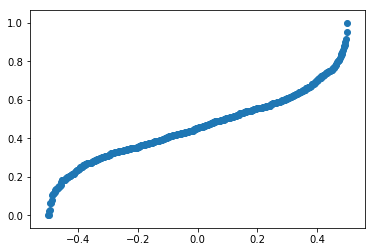

In [12]:
# 将 x,y 拼接并按照 y 值大小排序, 观察 y 的性质
x_final = x_pca
print(np.shape(x_final), np.shape(y)) # x_final = [500x82], y = [500x1]
xy = np.column_stack((x_final, y)) # xy = [x_final, y], [500x83]
print(np.shape(xy))
xy_sortby_y = xy[xy[:, -1].argsort()]
y_sorted = xy_sortby_y[:, -1]
ymin = np.min(y_sorted)
ymax = np.max(y_sorted)
y_scl = (y_sorted - ymin) / (ymax - ymin)
xy_sortby_y[:, -1] = y_scl
x_test = np.linspace(-0.5, 0.5, 500)
plt.scatter(x_test, xy_sortby_y[:, -1])
plt.show()

In [13]:
# 导出数据到 matlab 去拟合 y
# print(', '.join([str(_) for _ in list(xy_sortby_y[:, -1])]))

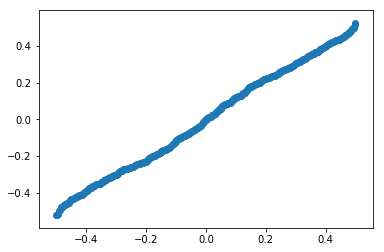

In [14]:
# 发现非线性关系后 规整化 y 并重新组装
def fu(y): # f: y -> u
    a = 0.172020013840487
    b = 2.355955139758581
    c = 0.028332501141596
    d = 0.450477070771684
    return (np.arctan((y - d) / a) - c) / b

def gy(u): # g: u -> y
    a = 0.172020013840487
    b = 2.355955139758581
    c = 0.028332501141596
    d = 0.450477070771684
    return a * np.tan(b * u + c) + d

def scalar(a, amax, amin):
    return (a - amin) / (amax - amin)

def rebuild(a, amax, amin):
    return a * (amax - amin) + amin;
    
y_smooth = fu(y_scl)
xy_sortby_y[:, -1] = y_smooth
plt.scatter(x_test, y_smooth)
plt.show()

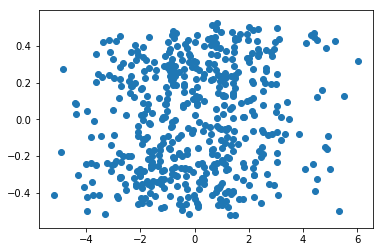

In [15]:
# 修改 idx 来观察输入特征 xy_sortby_y[:, idx] 的形态
# idx: 5, 6, 12, 16, 20, 24 => 中心出现一额外点
idx = 5
plt.scatter(xy_sortby_y[:, idx], xy_sortby_y[:, -1])
plt.show()

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


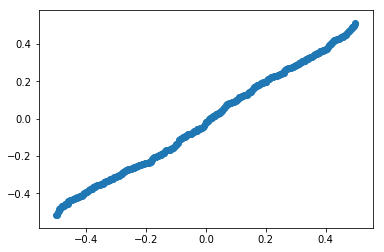

In [16]:
# 5折交叉验证, 这里使用了变换后的 y
from sklearn.cross_validation import train_test_split
x_now, y_now = xy_sortby_y[:, :-1], xy_sortby_y[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x_now, y_now, random_state=33, test_size=0.2)
plt.scatter(np.linspace(-0.5, 0.5, 400), sorted(y_train))
plt.show()

In [17]:
# 线性回归
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
y_pred = model_lr.predict(x_test)
yh_rebuild = rebuild(gy(y_pred), ymin, ymax)
ytest_rebuild = rebuild(gy(y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('Linear Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('Linear Regression MAE Error: ', mae_err)
print(model_lr.score(x_test, y_test))

Linear Regression MSE Error:  0.0544382082017
Linear Regression MAE Error:  0.180436656716
0.0182092174638


In [18]:
# 支持向量回归 高斯径向基核函数
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
model_svr_rbf = SVR(kernel='rbf')
model_svr_rbf.fit(x_train, y_train)
y_pred = model_svr_rbf.predict(x_test)
yh_rebuild = rebuild(gy(y_pred), ymin, ymax)
ytest_rebuild = rebuild(gy(y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('Support Vector Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('Support Vector Regression MAE Error: ', mae_err)
print(model_svr_rbf.score(x_test, y_test))

Support Vector Regression MSE Error:  0.0417444704502
Support Vector Regression MAE Error:  0.15734942122
0.173021980519


In [19]:
# XGBoost 回归
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(x_train, y_train)
y_pred = xgbr.predict(x_test)
yh_rebuild = rebuild(gy(y_pred), ymin, ymax)
ytest_rebuild = rebuild(gy(y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MAE Error: ', mae_err)
print(xgbr.score(x_test, y_test))

XGBoost Regression MSE Error:  0.0433773747035
XGBoost Regression MAE Error:  0.165362583497
0.15098883343


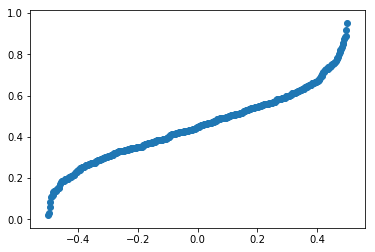

In [20]:
# 不再使用变换后的 y
from sklearn.cross_validation import train_test_split
x_now, y_now = xy_sortby_y[:, :-1], y_scl
x_train, x_test, y_train, y_test = train_test_split(x_now, y_now, random_state=33, test_size=0.2)
plt.scatter(np.linspace(-0.5, 0.5, 400), sorted(y_train))
plt.show()

In [21]:
# 线性回归 #2
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
y_pred = model_lr.predict(x_test)
yh_rebuild = rebuild((y_pred), ymin, ymax)
ytest_rebuild = rebuild((y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('Linear Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('Linear Regression MAE Error: ', mae_err)
print(model_lr.score(x_test, y_test))

Linear Regression MSE Error:  0.0455571079232
Linear Regression MAE Error:  0.174820732804
0.0794028670981


In [22]:
# 支持向量回归 高斯径向基核函数 #2
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
model_svr_rbf = SVR(kernel='rbf')
model_svr_rbf.fit(x_train, y_train)
y_pred = model_svr_rbf.predict(x_test)
yh_rebuild = rebuild((y_pred), ymin, ymax)
ytest_rebuild = rebuild((y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('Support Vector Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('Support Vector Regression MAE Error: ', mae_err)
print(model_svr_rbf.score(x_test, y_test))

Support Vector Regression MSE Error:  0.0430075390237
Support Vector Regression MAE Error:  0.158417655228
0.130923385542


In [23]:
# XGBoost 回归 #2
from xgboost import XGBRegressor
xgbr = XGBRegressor()
xgbr.fit(x_train, y_train)
y_pred = xgbr.predict(x_test)
yh_rebuild = rebuild((y_pred), ymin, ymax)
ytest_rebuild = rebuild((y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('XGBoost Regression MAE Error: ', mae_err)
print(xgbr.score(x_test, y_test))

XGBoost Regression MSE Error:  0.0435935340927
XGBoost Regression MAE Error:  0.162636702775
0.119081803705


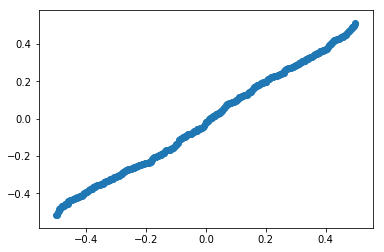

LASSO Regression MSE Error:  0.0513094061752
LASSO Regression MAE Error:  0.181960130591
-0.0337514121845
Ridge Regression MSE Error:  1.12514092601
Ridge Regression MAE Error:  0.339075474218
-0.330518045072


In [24]:
# 特装提升 增加 2 次多项式特征
from sklearn.preprocessing import PolynomialFeatures
poly2 = PolynomialFeatures(degree=2)
x_now, y_now = xy_sortby_y[:, :-1], xy_sortby_y[:, -1]
x_now_poly2 = poly2.fit_transform(x_now)
x_train_poly2, x_test, y_train_poly2, y_test = train_test_split(x_now_poly2, y_now, random_state=33, test_size=0.2)
plt.scatter(np.linspace(-0.5, 0.5, 400), sorted(y_train_poly2))
plt.show()

# LASSO
from sklearn.linear_model import Lasso
lasso_poly2 = Lasso()
lasso_poly2.fit(x_train_poly2, y_train_poly2)
y_pred = lasso_poly2.predict(x_test)
yh_rebuild = rebuild(gy(y_pred), ymin, ymax)
ytest_rebuild = rebuild(gy(y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('LASSO Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('LASSO Regression MAE Error: ', mae_err)
print(lasso_poly2.score(x_test, y_test))

# Ridge
from sklearn.linear_model import Ridge
ridge_poly2 = Ridge()
ridge_poly2.fit(x_train_poly2, y_train_poly2)
y_pred = ridge_poly2.predict(x_test)
yh_rebuild = rebuild(gy(y_pred), ymin, ymax)
ytest_rebuild = rebuild(gy(y_test), ymin, ymax)
mse_err = mean_squared_error(yh_rebuild, ytest_rebuild)
print('Ridge Regression MSE Error: ', mse_err)
mae_err = mean_absolute_error(yh_rebuild, ytest_rebuild)
print('Ridge Regression MAE Error: ', mae_err)
print(ridge_poly2.score(x_test, y_test))

In [25]:
x_now, y_now = xy_sortby_y[:, :-1], xy_sortby_y[:, -1]

In [26]:
# Summary 最终流程
# 保留列
remain_header = list(remain_column2)
save_pickle('remain_header.bin', remain_header)
# 模型本体
save_pickle('svr_rbf.model.bin', model_svr_rbf)
# 反演函数
def gy(u): # g: u -> y
    a = 0.172020013840487
    b = 2.355955139758581
    c = 0.028332501141596
    d = 0.450477070771684
    return a * np.tan(b * u + c) + d
ys = [ymin, ymax]
save_pickle('ys.bin', ys)